# A quick introduction to reservoir computing

## Temporal data

Many observables are not static but change over time, giving the data that represents them a temporal component. Typical examples are audio or video data or bio-signals, such as ECG.

In many cases it is not sufficient to look at the signal at individual time points in isolation. Instead, temporal relations need to be considered. For example, utterances of the words "yes" and "say" may have similar frequency spectra. What makes the difference is the order at which the different frequency components appear.

In real-time analysis systems, such as keyword detectors, this means that not only the current input but also past inputs need to be taken into account. One way of doing this is buffering the data and presenting as instantaneous input the signal recorded over a time range. However, for some ultra-low power applications, buffering may already consume too much energy. Another approach is therefore to store information about past inputs implicitly in the processing system by equipping it with an internal state that depends both on its past state and the current input.

_illustration of buffer + system vs system with internal state_

## Quick recap: Leaky Integrate and Fire (LIF) model

In the morning session we saw the Leaky Integrate and Fire (LIF) neuron model. It has an internal state, its membrane potential, whose dynamics are described as follows:

$$\tau_m \dot{V_{m}} = - V_{m}(t) + I_{s} + I_{bias}$$

where $\tau_m$ is the membrane time constant, which determines how much the neuron depends on its previous states and inputs and therefore defines the neuron's memory; and $I_{bias}$ is a constant bias. The synaptic current $I_{s}$ is obtained by low-pass filtering the incoming spike trains:

$\tau_s \dot{I}_s + I_s = \sum_j \delta(t-t_j)$

where $\delta(t - t_j)$ is a stream of spikes occurring at times $t_j$. The synaptic currents decay towards zero under the synaptic time constant $\tau_s$.

A neural network that consists of such LIF neurons fulfils the requirement from the section above: It is a system with an internal state that depends on its previous state as well as the current input. However, this implicit memory decays with a rate defined by the membrane time constant $\tau_{m}$, which in the the brain and in neuromorphic hardware is typically on the order of tens or at most a few hundreds of milliseconds. For many applications this is not enough.

## Recurrent neural networks

The network's memory can be expanded through a recurrent network architecture: Connections between neurons form a (directed) cyclic graph. This way, the signal can "travel" through the same neurons multiple times, allowing the network state to encode information from further back in the past.

An example of a non-spiking recurrent neural network where the units have an internal state are long short term memory networks (LSTMs).

_illustration_

## Reservoir computing

We could now use algorithms such as back-propagation through time (BPTT) to train such a recurrent network. However, it turns out that it also possible to take a randomly connected layer of neurons, called a reservoir, together with an output layer - called readout - and train only the input weights of the latter. This approach is referred to reservoir computing. Specifically, one speaks of an Echo State Network (ESN) in the case of non-spiking neurons and a Liquid State Machine (LSM) for spiking neurons.

But how is this ever going to work? The idea is that due to the random connections each neuron in the reservoir gets as input an individual combination of the previous network state and the input to the network. Therefore every neuron's state is a function of the input signal that differs from that of the other neurons in the layer. 
In other words we have a non-linear projection of the input signal into a high dimensional space. We then train our readout layer to find a linear combination of the reservoir states that best approximates the function we want to apply to the input. This is a form of the "kernel trick", with random kernel functions, defined by the connecitons in the reservoir.

In a nutshell, our reservoir network does two important things:
1. It incorporates information about past inputs into its state through recurrent connections.
2. It expands the dimensionality of the input signal in a non-linear way.

_illustration_

### State trajectory
As we now discussed, we expect a pulse input to the reservoir to have an affect on its state (its neuron activities) also after the input pulse ends. However, 
- effect should decay with time 
- avoid chaotic dynamics
we would like the reservoir to eventually return to its initial state, if no further input is provided. This is called the echo-state property.

_illustration of reservoir state trajectory_

### Training of readout
The readout performs a linear combination of the reservoir states. In case of a spiking reservoir it often consists of a layer of LIF neurons. Because the synapses low-pass filter the reservoir spike trains, the training can be done on analog values (the synaptic currents).

The readout is a single, feed-forward layer, which makes it easy to train. You can, for example use linear regression to find the weights that optimally map the synaptic currents to your target trace.

## From signal to spikes

Between spiking neurons information is exchanged in the form of spike trains - discrete events in time which are often represented as a sum over Dirac delta functions. However, in signals often consist of analog values and therefore need to be converted to spikes somehow. There are many different ways of encoding information in spikes. In the following we will present two of them.

### Rate encoding
An analog value can be approximately represented by a neuron's firing rate. The higher the value, the faster the neuron fires.

This can be implemented by an inhomogenous Poisson point process with Poisson parameter being a function of the analog value.

Another method is to inject the value directly as a current into the LIF neuron:
$$\tau_m \dot{V_{m}} = - V_{m}(t) + I_{s} + I_{bias}$$
where $I_s$ is now a function of the signal that is to be encoded. Large values for $I_{s}$ will make $V_m$ reach the firing threshold more quickly and therefore result in a larger firing rate.

Note that with both methods there is a minimum value below which the neuron will not fire.

We will use the second approach to convert a sine wave into a spike train. For this we will use [Rockpool](https://aictx.gitlab.io/rockpool/), an open source package for designing and simulating spiking neural networks. Its core elements are `Layer` classes that represent different types of spiking or non-spiking neuron populations. Signals are stored in `TimeSeries` objects, which are either time continuous (`TSContinous`) or event-based (`TSEvent`).

The `FFIAFNest` layer represents a feed-forward layer of LIF neurons that receives analog values as input and uses [nest](https://www.nest-simulator.org/) as simulation backend.



Text(0.5, 0, 'Time [s]')

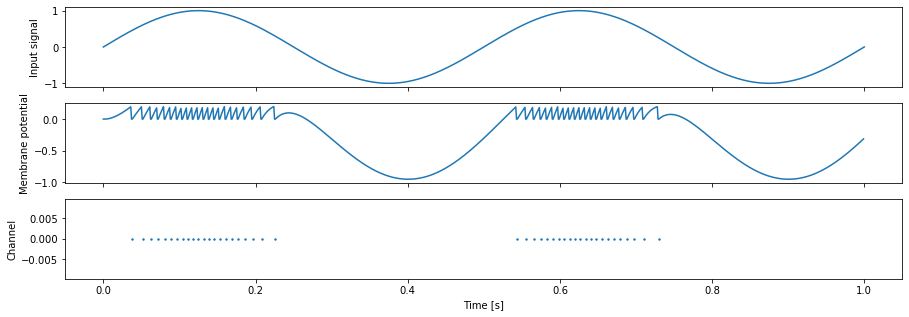

In [26]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from rockpool import TSContinuous
from rockpool.layers import FFIAFNest

# - Input signal
time = np.linspace(0, 1, 1001)
freq = 2
sine_samples = np.sin(time * freq * 2 * np.pi).reshape(-1,1)  # + 1.5
cosine_samples = np.cos(time * freq * 2 * np.pi).reshape(-1,1)  # + 1.5
sine_ts = TSContinuous(
    time,
    # np.hstack((sine_samples, cosine_samples)),
    sine_samples    
)

# - Plot
fig, axes = plt.subplots(3, sharex=True, figsize=(15,5))
sine_ts.plot(target=axes[0])
axes[0].set_ylabel("Input signal")

# - "Layer" of one LIF neuron
weights = np.eye(1)
lif_layer = FFIAFNest(
    weights=weights,
    bias=0,
    v_reset=0,
    v_rest=0,
    v_thresh=0.2,
    tau_mem=0.025,
    dt=0.001,
    record=True,
)

# - Evolve layer to obtain spiking output
spike_train = lif_layer.evolve(sine_ts)

# - Plot
lif_layer.recorded_states.plot(target=axes[1])
axes[1].set_ylabel("Membrane potential")
spike_train.clip(channels=0).plot(target=axes[2], s=2)
# spike_train.clip(channels=1).plot(target=axes[2], s=2)
axes[2].set_ylabel("Channel")
axes[2].set_xlabel("Time [s]")

### Delta-sigma encoding

Delta-sigma encoding is another method of translating an analog signal to spikes. Here each analog signal dimension is encoded by two spiking channels. One emits a spike whenever the value increases by a fixed amount and the other channel emits a spike whenever the value decreases by a fixed amount. This means that spikes are only emitted when the signal changes, i.e. when "something is happening". This method is also referred to as Lebesgue sampling.

We will again use Rockpool to 
 
 _Show examples in Rockpool of how to convert signal to spikes_